In [1]:
import time
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, roc_curve
import torch
import torch.nn.functional as F
import numpy as np
from xgnn_src.shared_networks import OnlineKG, NaiveTeacher
from xgnn_src.graph.gcn import GCN, GCN_MLP
from xgnn_src.graph.utils import load_data, get_mask, draw_simple_graph
import pickle as pkl
from sklearn.model_selection import StratifiedKFold
from xgnn_src.graph.dataloader import GCDataLoader

In [2]:
import collections
import dgl
import networkx as nx

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [4]:
def get_mask(g, base, explainer, undir=True, threshold=0.5):
    base.eval()
    explainer.eval()
    with torch.no_grad():
        base(g, g.ndata['attr'])
        embedding = g.ndata['emb']
        edge_weight = explainer.edge_mask.compute_adj(g, embedding)
        edge_weight = explainer.edge_mask.edge_mlp(edge_weight)
        mask = explainer.edge_mask.concrete(edge_weight, beta=5.)
#         print(mask)
#         mask = F.sigmoid(edge_weight)
#         print(mask)
    with g.local_scope():
        num_nodes = g.num_nodes()
        adj = [[0.] * num_nodes for _ in range(num_nodes)] 
        src, dst = g.edges()
        for i, (s, d) in enumerate(zip(src, dst)):
            s, d = s.item(), d.item()
            m = mask[i].item()
            if m < threshold:
                adj[s][d] = 0.0
                if undir:
                    continue
                adj[d][s] = 0.0
            else:
                adj[s][d] = m
        weight = []
        for s, d in zip(src, dst):
            s, d = s.item(), d.item()
            weight.append(adj[s][d])
        mask = np.array(weight)
    return mask

def obtain_predictions(tpr, fpr, threshold, preds):
    optimal_proba_cutoff = sorted(zip(tpr - fpr, threshold), key=lambda i: i[0], reverse=True)[0][1]
    roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in preds]
    return roc_predictions

In [5]:
dataset, dim_nfeats, gclasses = load_data('BA')

Done loading data from cached files.


- Low kl term => focus on class 0 (<1)
- KL >=1 => focus on both
- KL too large => 

In [6]:
with open('./graph/ckpt/gcn/ba_f5.dat', 'rb') as f:
    dataloader, idx = pkl.load(f)
train_idx, valid_idx = idx

In [7]:
base = GCN(10, 64, 2, 5, 0.5, 'max', 'last')
explainer = GCN_MLP(10, 64, 2, 5, 0.5, 64 * 2, 'max', 'last', 'sigmoid', False, 'bn')
teacher = NaiveTeacher(2, 'mean')
online_mode = OnlineKG(base, explainer, teacher).to(torch.device('cpu'))

norm type: bn
norm type: bn


In [8]:
model = torch.load('./graph/ckpt/gcn/old/ba_max_last_200_f5_kl4.pt', map_location='cuda:0')
online_mode.load_state_dict(model)

<All keys matched successfully>

In [10]:
preds, preds2, labels = [], [], []
online_mode.eval()
with torch.no_grad():
    for i, v in enumerate(valid_idx):
        g, l = dataset[v]
        with g.local_scope():
            pred, _ = online_mode.base(g, g.ndata['attr'])
            embedding = g.ndata['emb']
            p2, _ = online_mode.explainer(g, g.ndata['attr'], embedding)
            preds.append(torch.argmax(pred).item())
            preds2.append(torch.argmax(p2).item())
            labels.append(l.item())

In [11]:
preds, preds2, labels = np.array(preds), np.array(preds2), np.array(labels)

In [12]:
print('recall explainer', recall_score(preds2, labels))
print('f1 explainer', f1_score(preds2, labels))
print('acc explainer', accuracy_score(preds2, labels))
print('recall base', recall_score(preds, labels))
print('f1 base', f1_score(preds, labels))
print('acc base', accuracy_score(preds, labels))

recall explainer 1.0
f1 explainer 1.0
acc explainer 1.0
recall base 1.0
f1 base 1.0
acc base 1.0


In [13]:
wrong = (np.array(preds) != np.array(labels)).nonzero()[0]
positive = preds.nonzero()[0]
negative = (preds == 0).nonzero()[0]
false_positive = np.intersect1d(wrong, positive)
false_negative = np.intersect1d(wrong, negative)
true_positive = np.setdiff1d(positive, false_negative)

In [41]:
positive

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199])

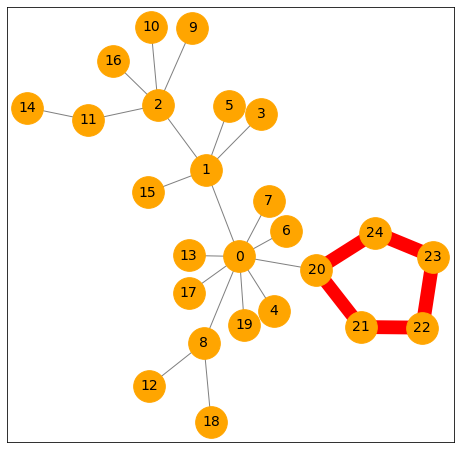

In [32]:
g1 = dataset[valid_idx[1]][0]
weight1 = get_mask(g1, base, explainer)
draw_simple_graph(g1, weight1 * 13 + 1)
plt.savefig("./graph/images/important_subgraphs/ba2motif/ba2motif_1.pdf", format="pdf", dpi=300)

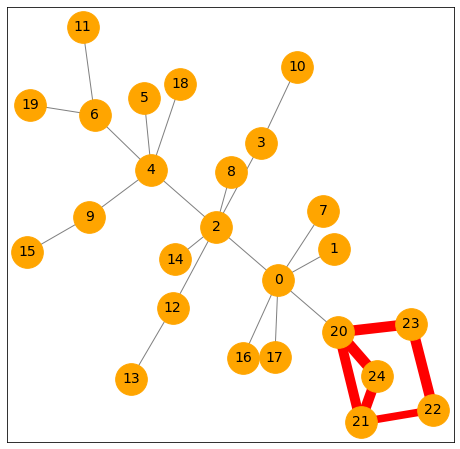

In [19]:
g2 = dataset[500][0]
weight2 = get_mask(g2, base, explainer)
draw_simple_graph(g2, weight2 * 10 + 1)
# plt.savefig("./graph/images/important_subgraphs/ba2motif/150.svg", format="svg", dpi=300)

In [36]:
eval_graph_idxs = list(range(0,100)) + list(range(500,600))

In [18]:
import pickle as pkl

In [23]:
with open('./graph/datasets/BA-2motifs.pkl','rb') as fin:
    adjs, features, labels = pkl.load(fin)

In [32]:
from scipy.sparse import coo_matrix, csr_matrix
def get_edge_labels(adj, insert=20):
    real = []
    skip_lv = insert + 5
    for r, c in list(zip(adj.row, adj.col)):
        if r >= insert and r < skip_lv and c >= insert and c < skip_lv:
            real.append(1)
        else:
            real.append(0)
    return real

In [74]:
def symmetrize_weight(g, weight):
    adj = g.adj(scipy_fmt="coo")
    adj.data = weight
    adj_t = adj.transpose()
    adj = adj + adj_t
#     w2 = adj_t.data
#     return np.maximum(weight, w2)
    return adj.data

In [76]:
s = time.time()
reals, preds = [], []
for i in eval_graph_idxs:
    g = dataset[i][0]
    weight = get_mask(g, base, explainer, True, threshold=0.0)
    weight = symmetrize_weight(g, weight)
    label = edge_labels[i]
    fpr, tpr, threshold = roc_curve(label, weight)
    pred = obtain_predictions(tpr, fpr, threshold, weight)    
    reals.extend(label)
    preds.extend(pred)

pr = precision_score(reals, preds)
re = recall_score(reals, preds)
f1 = 2 * pr * re / (pr + re)
print("Precision %.4f, Recall %.4f F1 %.4f" % (pr, re, f1))
print(time.time() - s)

Precision 0.9285, Recall 1.0000 F1 0.9629
1.50650954246521
